# Nuclear magnetic resonance frequency of Tl in TlF as a function of applied electric field

This document presents a calculation of the nuclear magnetic resonance frequency of thallium in a thallium fluoride molecule when an external applied electric field is applied on the molecule. The motivation is the CeNTREX experiment, which uses a measurement of this NMR frequency to look for T-reversal violating interactions in the Tl nucleus by applying a large (~30 kV/cm) electric field on TlF molecules in a molecular beam experiment. Due to the small magnitude of any T-violating effects  the systematics for the experiment need to be controlled carefully. One source of systematic error is a non-reversing electric field in the interaction region of the experiment, which can mimic the signal due to an electric dipole -like interaction. Therefore we want to calculate how large the EDM like signal due to a non-reversing electric field is, and this is what is done in this report.

The calculation uses the 'TlF hyperfine hamiltonian.ipynb' code written by Jakob Kastelic for generating the hyperfine Hamiltonian of TlF. Once the Hamiltonian is known we simply diagonalize it to find the energies and stationary states at various electric fields.

First import necessary packages and the pregenerated Hamiltonian:

In [6]:
import numpy as np
import sympy
import pickle
import matplotlib.pyplot as plt
%matplotlib notebook
from classes import UncoupledBasisState,CoupledBasisState, State
from functions import sort_evals, distancematrix
with open("hamiltonians_symbolic.py", 'rb') as f:
    hamiltonians = pickle.load(f)
with open("Hff_alt_mat.py", 'rb') as f:
    Hff_alt_mat_m = pickle.load(f)["Hff_alt_mat"]
    
Jmax = sympy.Integer(6) # max J value in Hamiltonian
I_Tl = 1/2             # I1 in Ramsey's notation/
I_F  = 1/2             # I2 in Ramsey's notation

def ni_range(x0, x1, dx=1):
    # sanity check arguments
    if dx==0:
        raise ValueError("invalid parameters: dx==0")
    if x0>x1 and dx>=0:
        raise ValueError("invalid parameters: x0>x1 and dx>=0")
    if x0<x1 and dx<=0:
        raise ValueError("invalid parameters: x0<x1 and dx<=0")
        
    # generate range list
    range_list = []
    x = x0
    while x < x1:
        range_list.append(sympy.Number(x))
        x += dx
    return range_list

QN = [UncoupledBasisState(J,mJ,I_Tl,m1,I_F,m2)
      for J  in ni_range(0, Jmax+1)
      for mJ in ni_range(-J,J+1)
      for m1 in ni_range(-I_Tl,I_Tl+1)
      for m2 in ni_range(-I_F,I_F+1)
     ]

Convert the `sympy` `Matrix` into a `numpy` array:

In [2]:
%%time
variables = [
    sympy.symbols('Brot'),
    *sympy.symbols('c1 c2 c3 c4'),
    sympy.symbols('D_TlF'),
    *sympy.symbols('mu_J mu_Tl mu_F')
]

lambdified_hamiltonians = {
    H_name : sympy.lambdify(variables, H_matrix)
    for H_name, H_matrix in hamiltonians.items()
}

Wall time: 6.56 s


Insert numerical constants into Hamiltonian (all in units of Hz):

In [3]:
%%time
Brot = 6689920000
c1 = 126030.0
c2 = 17890.0
c3 = 700.0
c4 = -13300.0
D_TlF = 4.2282 * 0.393430307 *5.291772e-9/4.135667e-15 # [Hz/(V/cm)]
mu_J = 35
mu_Tl = 1240.5
mu_F = 2003.63

H = {
    H_name : H_fn(
        Brot,
        c1, c2, c3, c4,
        D_TlF,
        mu_J, mu_Tl, mu_F
    )
    for H_name, H_fn in lambdified_hamiltonians.items()
}

Wall time: 27.9 ms


### Find the energies

Above, we have evaluated the matrix elements for the zero-field Hamiltonian $H_\text{ff}$, as well as the $\vec E=1=\vec B$ cases. For general fields $\vec E,\vec B$, the Hamiltonian is

$$
H=H_\text{ff}
+
\begin{pmatrix}
E_x\\E_y\\E_z
\end{pmatrix}
\cdot
\begin{pmatrix}
H^\text{S}_x\\H^\text{S}_y\\H^\text{S}_z
\end{pmatrix}
+
\begin{pmatrix}
B_x\\B_y\\B_z
\end{pmatrix}
\cdot
\begin{pmatrix}
H^\text{Z}_x\\H^\text{Z}_y\\H^\text{Z}_z
\end{pmatrix}.
$$

When looking at the Zeeman/Stark effects on the hyperfine structure, the rotational structure is not of interest, so I subtract it for clarity in the following `spectrum()` function. It evaluates the above Hamiltonian for each point on the array of fields, and returns a list of energy levels, sorted by size:

In [4]:
def spectrum(Ex_arr,Ey_arr,Ez_arr,Bx_arr,By_arr,Bz_arr):
    energies_arr = []
    energies_rot_arr = []
    states_arr = []
    for Ex,Ey,Ez,Bx,By,Bz in zip(Ex_arr,Ey_arr,Ez_arr,Bx_arr,By_arr,Bz_arr):
        HamE = H["Hff_alt"] + \
            Ex*H["HSx"]  + Ey*H["HSy"] + Ez*H["HSz"] + \
            Bx*H["HZx"]  + By*H["HZy"] + Bz*H["HZz"]
        D, V = np.linalg.eigh(HamE)
        idx = D.argsort() 
        D = D[idx]
        V = V[:,idx]
        
        # Subtract away rotational energy for easier viewing of substructure
        hfs_mat = []
        for i,state in enumerate(QN):
            J = state.J
            hfs_mat.append(D[i] - J*(J +1)*Brot)
        hfs_kHz = np.array(hfs_mat)/1000

        energies_arr.append(hfs_kHz)
        energies_rot_arr.append(D)
        states_arr.append(V)
    return np.array(energies_arr), np.array(energies_rot_arr), np.array(states_arr)

<IPython.core.display.Javascript object>


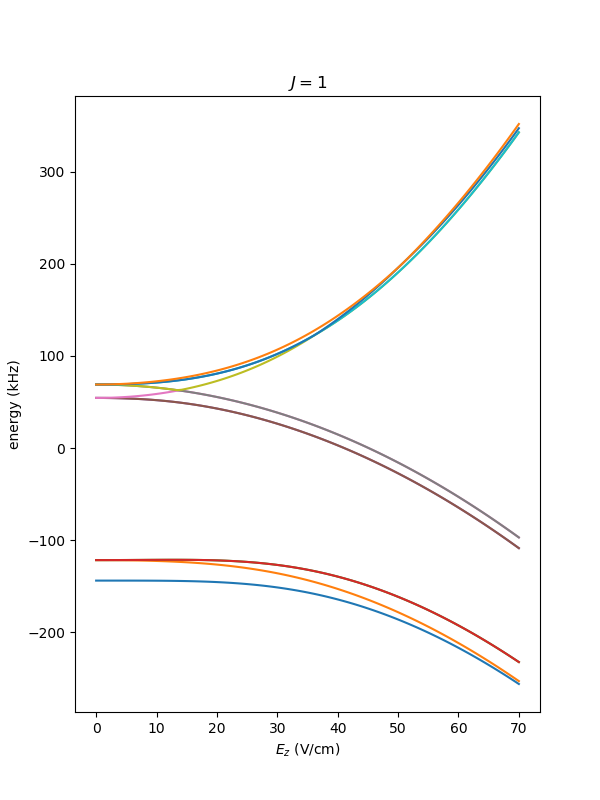

In [7]:
Ez = np.linspace(0,70,100)
#Bz = 18.4 * np.ones(Ez.shape)
Bz = np.zeros(Ez.shape)
Ex = np.zeros(Ez.shape)
Ey = np.zeros(Ez.shape)
Bx = np.zeros(Ez.shape)
By = np.zeros(Ez.shape)

energies = spectrum(Ex,Ey,Ez,Bx,By,Bz)[0]

for i in range(4,16):
    plt.plot(Ez, energies.T[i])
    
plt.title("$J=1$")
plt.xlabel("$E_z$ (V/cm)")
plt.ylabel("energy (kHz)")

fig_ramsey = plt.gcf()
fig_ramsey.set_size_inches(6, 8)
plt.show()

In [8]:
energies[0]

array([-3.32500016212924, -3.32500015259357, -3.32500012680745,
       9.97499999365097, -143.744999979019, -121.506217470169,
       -121.506217428207, -121.506217370987, 54.4462172470093,
       54.4462174053192, 54.4462174434662, 68.9849998207092,
       68.9849998950958, 68.9849998970032, 68.9849999027252,
       68.9849999237061, -217.455000007629, -217.454999847412,
       -217.454999847412, -172.936149284363, -172.936149200439,
       -172.936149177551, -172.936149124146, -172.936149116516,
       105.876149108887, 105.876149162292, 105.876149208069,
       105.876149253845, 105.876149269104, 141.094999801636,
       141.094999862671, 141.094999877930, 141.094999908447,
       141.094999961853, 141.094999961853, 141.094999977112,
       -289.764999923706, -289.764999908447, -289.764999877930,
       -289.764999816895, -289.764999771118, -225.820051376343,
       -225.820051361084, -225.820051345825, -225.820051330566,
       -225.820051330566, -225.820051239014, -225.82005123901

# Energy for $ J = 1, m_J = \pm 1 $

At high electric fields only mJ, m1 and m2 are good quantum numbers so we're going to calculate some energies in this basis. However, we must also start from some well defined state in the coupled angular momentum basis.

We're primaly interested in how the energy of the state with $ J = 1, m_J = \pm 1 $ varies with the electric field strength since this is the state in which the measurement occurs. First we'll study the different coupled states from which we can start:
- given that J = 1 and both nuclear spins are $I_1 = I_2 = 1/2 $ so can have $F = 0,1,1,2$ and $F_1 = 1/2,1/2,3/2,3/2 $
- $m_J = 1$  so can have $ m_F = 0,1,1,2 $
- In Ramseys experiment the transition they used was $|m_J = -1, m_1 = -1/2, m_2 = -1/2\rangle \rightarrow |m_J = -1, m_1 = +1/2, m_2 = -1/2\rangle $, or alternatively $|m_J = +1, m_1 = +1/2, m_2 = +1/2\rangle \rightarrow |m_J = +1, m_1 = -1/2, m_2 = +1/2\rangle $

In [12]:
#Set the possible values of the quantum numbers:
Fs = (0,1,1,2)
mFs = (0,1,2)
F1s = (1/2,1/2,3/2,3/2)
J = 1
I1 = 1/2
I2 = 1/2

In [13]:
for i in range(0,len(Fs)):
    F = Fs[i]
    F1 = F1s[i]
    for mF in mFs:
        if mF <= F:
            state = CoupledBasisState(F,mF,F1,J,I1,I2)
            state.print_quantum_numbers()
            state.transform_to_uncoupled().print_state()
            print("")

|F = 0, m_F = 0, F1 = 1/2, J = 1, I1 = 1/2, I2 = 1/2>
+0.5774 x |J = 1, mJ = -1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2>
-0.4082 x |J = 1, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2>
-0.4082 x |J = 1, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2>
+0.5774 x |J = 1, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = -1/2>

|F = 1, m_F = 0, F1 = 1/2, J = 1, I1 = 1/2, I2 = 1/2>
-0.5774 x |J = 1, mJ = -1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2>
+0.4082 x |J = 1, mJ = 0, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2>
-0.4082 x |J = 1, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = -1/2>
+0.5774 x |J = 1, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = -1/2>

|F = 1, m_F = 1, F1 = 1/2, J = 1, I1 = 1/2, I2 = 1/2>
-0.5774 x |J = 1, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2>
+0.8165 x |J = 1, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2>

|F = 1, m_F = 0, F1 = 3/2, J = 1, I1 = 1/2, I2 = 1/2>
-0.4082 x |J = 1, mJ = -1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2>
-0.5774 x |J = 1, mJ = 0, I1 = 1/2, m1 = -1

Next calculate the energy of the $|F = 2, m_F = 2, F_1 = 3/2, J = 1, I_1 = 1/2, I_2 = 1/2>$ state as a function of electric field at zero magnetic field:

<IPython.core.display.Javascript object>


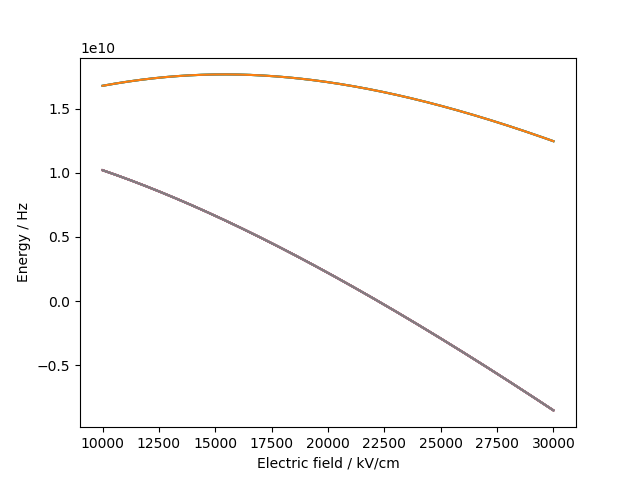

In [14]:
N_points = 1000
E_min = 10000
E_max = 30000
Ez = np.linspace(E_min,E_max,N_points)
Bz = np.zeros(Ez.shape)
Ex = np.zeros(Ez.shape)
Ey = np.zeros(Ez.shape)
Bx = np.zeros(Ez.shape)
By = np.zeros(Ez.shape)

energies, states = spectrum(Ex,Ey,Ez,Bx,By,Bz)[1:]
fig1, ax1 = plt.subplots(1,1)
ax1.set_xlabel("Electric field / kV/cm")
ax1.set_ylabel("Energy / Hz")

for i in range(4,16):
    ax1.plot(Ez, energies.T[i])

<IPython.core.display.Javascript object>


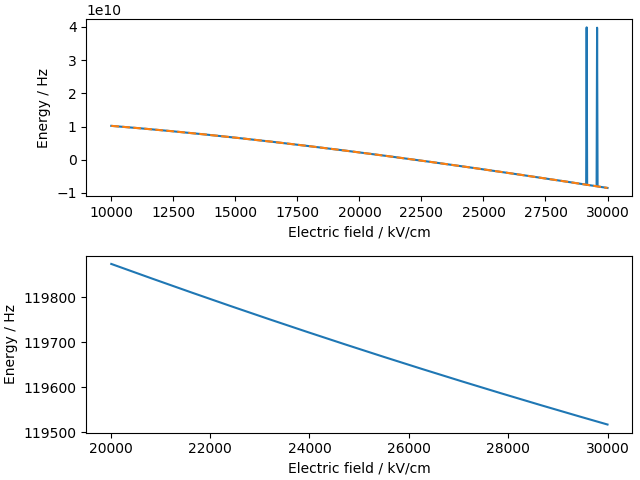

In [18]:
#Follow how |J = 1, mJ = 1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2> and 
#|J = 1, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2> change with electric field
J = 1 
mJ = 1
I1 = 1/2
m1 = 1/2
I2 = 1/2
m2 = 1/2

state_vector_p = UncoupledBasisState(J, mJ, I1, m1, I2, m2).make_state().state_vector(QN)
state_energy_p = np.zeros((len(energies),))
state_p = []

state_vector_m = UncoupledBasisState(J, mJ, I1, -m1, I2, m2).make_state().state_vector(QN)
state_energy_m = np.zeros((len(energies),))
state_m = []


for i in range(0,len(states)):
    state_index_p = np.argmax(np.abs(np.dot(states[i,:,:].T,state_vector_p)))
    state_energy_p[i] = energies[i,state_index_p]
    state_p.append(states[i,:,state_index_p])
    
    state_index_m = np.argmax(np.dot(states[i,:,:].T,state_vector_m)**2)
    state_energy_m[i] = energies[i,state_index_m]
    state_m.append(states[i,:,state_index_m])

deltaE = state_energy_p - state_energy_m
deltaE_plot = deltaE[deltaE<5e6]
Ez_plot = Ez[deltaE<5e6]


fig, ax = plt.subplots(2,1, constrained_layout = True)
ax[0].set_xlabel("Electric field / kV/cm")
ax[0].set_ylabel("Energy / Hz")
ax[0].plot(Ez, state_energy_p,label = 'm1 = +1/2')
ax[0].plot(Ez, state_energy_m,'--',label = 'm1 = -1/2')

ax[1].set_xlabel("Electric field / kV/cm")
ax[1].set_ylabel("Energy / Hz")
ax[1].plot(Ez_plot[500:], deltaE_plot[500:],label = 'm1 = +1/2')


Fit a line to the Energy vs Electric field plot for high field:

<IPython.core.display.Javascript object>


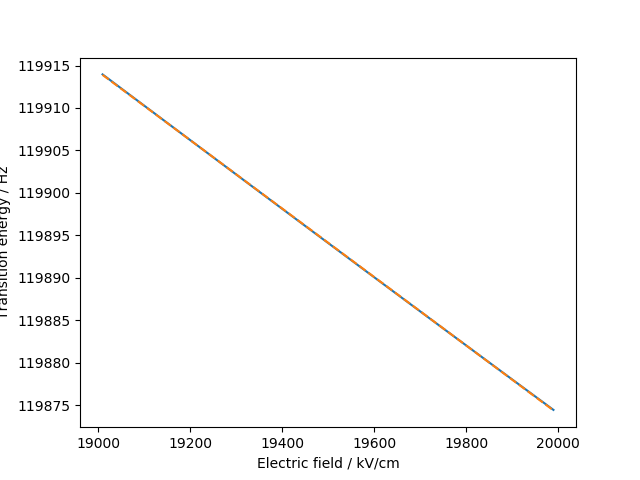

Text(29800,144329,'$Gradient =  -40.28 $ mHz/V')

In [21]:
#Import curve fitting package
from scipy.optimize import curve_fit

#Define equation of line
def line(x,k,c):
    return k*x+c

#Set min and max electric field for fit in kV/cm
E_fit_min = 19000
E_fit_max = 20000

#Calculate corresponding indices
n_min = int(np.round(N_points*(E_fit_min-E_min)/(E_max-E_min)))
n_max = int(np.round(N_points*(E_fit_max-E_min)/(E_max-E_min)))

E_fit = Ez[n_min:n_max]
deltaE_fit = deltaE[n_min:n_max]

#Fit line
popt, pcov = curve_fit(line, E_fit, deltaE_fit)

#Plot dem
fig, ax = plt.subplots(1,1)
ax.plot(E_fit,deltaE_fit)
ax.plot(E_fit,line(E_fit,*popt),'--')
ax.set_xlabel("Electric field / kV/cm")
ax.set_ylabel("Transition energy / Hz")
ax.text(29800,9+1.4432e5,"$Gradient =  {:.2f} $ mHz/V".format(popt[0]*1000))

## Error estimation

To estimate the error in the results, I will run the calculation multiple times with the parameters (c1, c2 etc.) pulled from normal distributions centered around the mean and with standard deviation as reported in Ramseys 1984 paper.

In [41]:
from tqdm import tqdm
N_sample = 10000

Brot = 6689920000
c1_array = np.random.normal(126030.0,120.0,N_sample)
c2_array = np.random.normal(17890.0,150.0,N_sample)
c3_array = np.random.normal(700.0,30.0,N_sample)
c4_array = np.random.normal(-13300.0,720.0,N_sample)
D_TlF_array = np.random.normal(4.2282 * 0.393430307 *5.291772e-9/4.135667e-15,0.0008 * 0.393430307 *5.291772e-9/4.135667e-15,N_sample)
mu_J_array = np.random.normal(35.0,15.0,N_sample)
mu_Tl_array = np.random.normal(1240.5,.3,N_sample)
mu_F_array = np.random.normal(2003.63,.04,N_sample)

N_points = 2
E_min = 19000
E_max = 20000
Ez = np.linspace(E_min,E_max,N_points)
Bz = np.zeros(Ez.shape)
Ex = np.zeros(Ez.shape)
Ey = np.zeros(Ez.shape)
Bx = np.zeros(Ez.shape)
By = np.zeros(Ez.shape)

frequency_Ramsey = []
gradient_Ramsey = []

for c1,c2,c3,c4,D_TlF,mu_J,mu_Tl,mu_F in tqdm(zip(c1_array, c2_array, c3_array,c4_array,D_TlF_array,mu_J_array,mu_Tl_array,mu_F_array)):
    H = {
        H_name : H_fn(
            Brot,
            c1, c2, c3, c4,
            D_TlF,
            mu_J, mu_Tl, mu_F
        )
        for H_name, H_fn in lambdified_hamiltonians.items()
    }

    energies,states = spectrum(Ex,Ey,Ez,Bx,By,Bz)[1:]
    
    state_energy_p = np.zeros((len(energies),))
    state_p = []

    state_energy_m = np.zeros((len(energies),))
    state_m = []
            
    state_index_p = np.argmax(np.abs(np.dot(states[-1,:,:].T,state_vector_p)))
    state_energy_p[:] = energies[:,state_index_p]

    state_index_m = np.argmax(np.dot(states[-1,:,:].T,state_vector_m)**2)
    state_energy_m[:] = energies[:,state_index_m]

    deltaE = state_energy_p - state_energy_m
    


    #Fit line
    popt, pcov = curve_fit(line, Ez, deltaE)
    
    frequency_Ramsey.append(deltaE[-1])
    gradient_Ramsey.append(popt[0]*1000)
    

0it [00:00, ?it/s]C:\Users\Oskari\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
10000it [08:27, 19.71it/s]


<IPython.core.display.Javascript object>


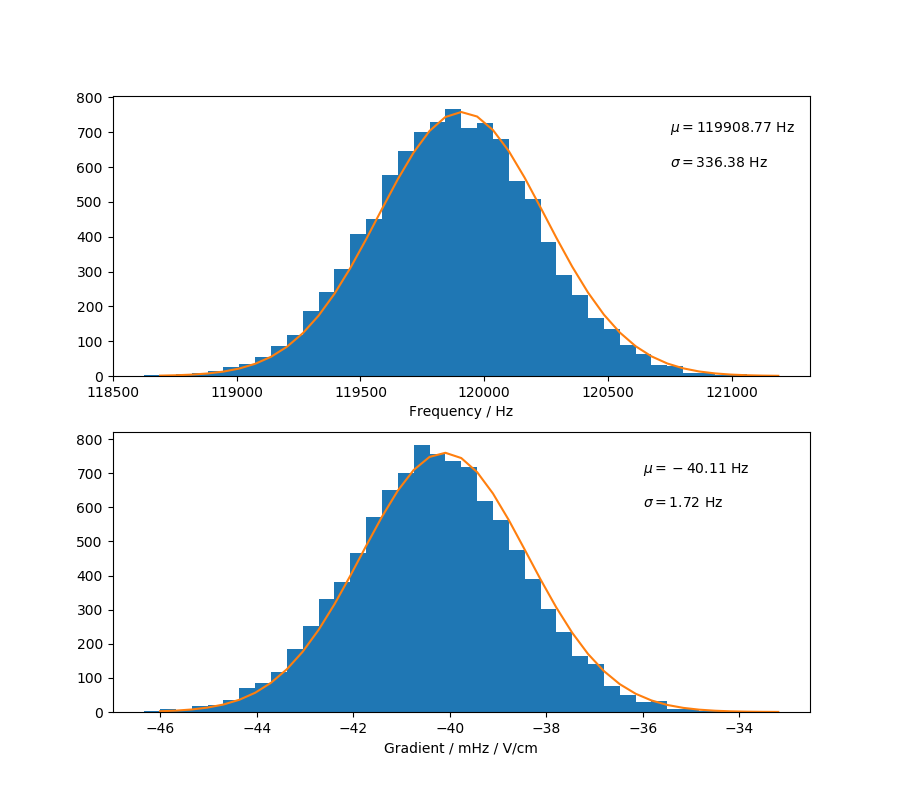

Text(-36,600,'$\\sigma =  1.72 $ Hz')

In [43]:
from scipy.optimize import curve_fit
def gaussian(x, amp, mu, sig):
    return amp*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

fig_hist, axs = plt.subplots(2,1,figsize = (9,8))
hist_freq = axs[0].hist(frequency_Ramsey,bins = 40)
axs[0].set_xlabel("Frequency / Hz")
x_freq,y_freq = np.diff(hist_freq[1])+hist_freq[1][:-1], hist_freq[0]
popt_freq, pcov_freq = curve_fit(gaussian, x_freq, y_freq,p0 = [60,120e3,300])
axs[0].plot(x_freq,gaussian(x_freq,*popt_freq))
axs[0].text(120750,700,"$\mu =  {:.2f} $ Hz".format(popt_freq[1]))
axs[0].text(120750,600,"$\sigma =  {:.2f} $ Hz".format(popt_freq[2]))



hist_grad = axs[1].hist(gradient_Ramsey, bins = 40)
axs[1].set_xlabel('Gradient / mHz / V/cm')
x_grad,y_grad = np.diff(hist_grad[1])+hist_grad[1][:-1], hist_grad[0]
popt_grad, pcov_grad = curve_fit(gaussian, x_grad, y_grad ,p0 = [60,-40,1])
axs[1].plot(x_grad,gaussian(x_grad,*popt_grad))
axs[1].text(-36,700,"$\mu =  {:.2f} $ Hz".format(popt_grad[1]))
axs[1].text(-36,600,"$\sigma =  {:.2f} $ Hz".format(popt_grad[2]))

Now repeat the calculation for 30 kV/cm

In [47]:
from tqdm import tqdm
N_sample = 10000

Brot = 6689920000
c1_array = np.random.normal(126030.0,120.0,N_sample)
c2_array = np.random.normal(17890.0,150.0,N_sample)
c3_array = np.random.normal(700.0,30.0,N_sample)
c4_array = np.random.normal(-13300.0,720.0,N_sample)
D_TlF_array = np.random.normal(4.2282 * 0.393430307 *5.291772e-9/4.135667e-15,0.0008 * 0.393430307 *5.291772e-9/4.135667e-15,N_sample)
mu_J_array = np.random.normal(35.0,15.0,N_sample)
mu_Tl_array = np.random.normal(1240.5,.3,N_sample)
mu_F_array = np.random.normal(2003.63,.04,N_sample)

N_points = 2
E_min = 29500
E_max = 30500
Ez = np.linspace(E_min,E_max,N_points)
Bz = np.zeros(Ez.shape)
Ex = np.zeros(Ez.shape)
Ey = np.zeros(Ez.shape)
Bx = np.zeros(Ez.shape)
By = np.zeros(Ez.shape)

frequency_Centrex = []
gradient_Centrex = []

for c1,c2,c3,c4,D_TlF,mu_J,mu_Tl,mu_F in tqdm(zip(c1_array, c2_array, c3_array,c4_array,D_TlF_array,mu_J_array,mu_Tl_array,mu_F_array)):
    H = {
        H_name : H_fn(
            Brot,
            c1, c2, c3, c4,
            D_TlF,
            mu_J, mu_Tl, mu_F
        )
        for H_name, H_fn in lambdified_hamiltonians.items()
    }

    energies,states = spectrum(Ex,Ey,Ez,Bx,By,Bz)[1:]
    
    state_energy_p = np.zeros((len(energies),))
    state_p = []

    state_energy_m = np.zeros((len(energies),))
    state_m = []
            
    state_index_p = np.argmax(np.abs(np.dot(states[-1,:,:].T,state_vector_p)))
    state_energy_p[:] = energies[:,state_index_p]

    state_index_m = np.argmax(np.dot(states[-1,:,:].T,state_vector_m)**2)
    state_energy_m[:] = energies[:,state_index_m]

    deltaE = state_energy_p - state_energy_m
    


    #Fit line
    popt, pcov = curve_fit(line, Ez, deltaE)
    if deltaE[-1]<5e6:
        frequency_Centrex.append(deltaE[-1])
        gradient_Centrex.append(popt[0]*1000)
    

0it [00:00, ?it/s]C:\Users\Oskari\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
10000it [09:23, 17.76it/s]


<IPython.core.display.Javascript object>


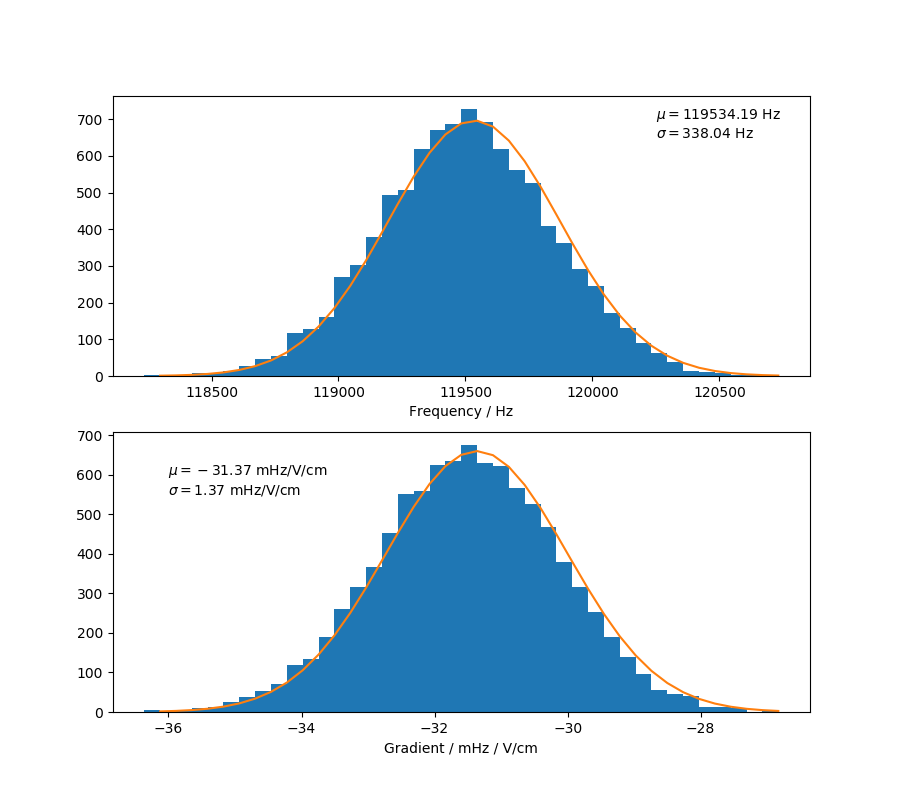

Text(-36,550,'$\\sigma =  1.37 $ mHz/V/cm')

In [55]:
from scipy.optimize import curve_fit
def gaussian(x, amp, mu, sig):
    return amp*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

fig_hist, axs = plt.subplots(2,1,figsize = (9,8))
hist_freq = axs[0].hist(frequency_Centrex,bins = 40)
axs[0].set_xlabel("Frequency / Hz")
x_freq,y_freq = np.diff(hist_freq[1])+hist_freq[1][:-1], hist_freq[0]
popt_freq, pcov_freq = curve_fit(gaussian, x_freq, y_freq,p0 = [700,120e3,300])
axs[0].plot(x_freq,gaussian(x_freq,*popt_freq))
axs[0].text(120250,700,"$\mu =  {:.2f} $ Hz".format(popt_freq[1]))
axs[0].text(120250,650,"$\sigma =  {:.2f} $ Hz".format(popt_freq[2]))



hist_grad = axs[1].hist(gradient_Centrex, bins = 40)
axs[1].set_xlabel('Gradient / mHz / V/cm')
x_grad,y_grad = np.diff(hist_grad[1])+hist_grad[1][:-1], hist_grad[0]
popt_grad, pcov_grad = curve_fit(gaussian, x_grad, y_grad ,p0 = [700,-40,1])
axs[1].plot(x_grad,gaussian(x_grad,*popt_grad))
axs[1].text(-36,600,"$\mu =  {:.2f} $ mHz/V/cm".format(popt_grad[1]))
axs[1].text(-36,550,"$\sigma =  {:.2f} $ mHz/V/cm".format(abs(popt_grad[2])))

## To do

- Fix sorting. I think sorting can actually be done simply by using matrix multiplication of the eigenvector matrices.